In [1]:
import os
import re
import gc
import nibabel as nib
from nibabel.affines import apply_affine
import numpy.linalg as npl
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('seaborn')

In [ ]:
# # Install required Latex dependencies for plots (Linux)
# ! sudo apt-get install texlive-latex-recommended 
# ! sudo apt install texlive-latex-extra
# ! sudo apt install dvipng
# ! sudo apt install cm-super

In [2]:
def get_figsize(fig_width=None, fig_height=None, columns=1):
    assert(columns in [1,2])

    if fig_width is None:
        fig_width = 3.39 if columns==1 else 6.9 # width in inches

    if fig_height is None:
        golden_mean = (np.sqrt(5)-1.0)/2.0    # Aesthetic ratio
        fig_height = fig_width*golden_mean    # height in inches

    MAX_HEIGHT_INCHES = 8.0
    if fig_height > MAX_HEIGHT_INCHES:
        print("WARNING: fig_height too large:" + fig_height + 
              "so will reduce to" + MAX_HEIGHT_INCHES + "inches.")
        fig_height = MAX_HEIGHT_INCHES
    
    return fig_width, fig_height

def latexify(fig_width=None, fig_height=None, columns=1):
    """Set up matplotlib's RC params for LaTeX plotting. Call this before plotting a figure.
    Code from https://nipunbatra.github.io/blog/visualisation/2014/06/02/latexify.html
    Adapted from http://www.scipy.org/Cookbook/Matplotlib/LaTeX_Examples
    
    Parameters
    ----------
    fig_width : float, optional, inches
    fig_height : float,  optional, inches
    columns : {1, 2}
    """
    fig_width, fig_height = get_figsize(fig_width, fig_height, columns)
    
    params = {'backend': 'ps',
              'text.latex.preamble': r'\usepackage{gensymb}',
              'axes.labelsize': 8, # fontsize for x and y labels (was 10)
              'axes.titlesize': 8,
              'font.size': 8, # was 10
              'legend.fontsize': 8, # was 10
              'xtick.labelsize': 8,
              'ytick.labelsize': 8,
              'text.usetex': True,
              'figure.figsize': [fig_width,fig_height],
              'font.family': 'serif'
    }

    matplotlib.rcParams.update(params)

In [3]:
latexify()  # Adjust default matplotlib settings for ACM Latex format.

In [4]:
centres_df = pd.read_csv('subject-centres.csv', dtype={'patientId': str, 'centerId': str, 'include': np.int8})
centres_df = centres_df[centres_df['include'] == 1] # Remove subjects with data issues.
centre8_subjects = centres_df[centres_df['centerId']=='8']['patientId'].tolist()

### Reading in Patch Data

In [5]:
root_dir = os.path.join('ot_da_v0', 'Data', 'SCSeg')
subjects = os.listdir(root_dir)
n_lesions={}; lesion_data={}; t2_data={}; t2s_data={}; t2_SC_data={}; t2s_SC_data={};

for subj in subjects:
    lesion_img = nib.load(os.path.join(root_dir, subj, 'SC', 'labelLesion.nii.gz'))
    lesion_img_data = lesion_img.get_fdata()
    n_lesions[subj] = max(np.unique(lesion_img_data.ravel()))

    res_dir = os.path.join(root_dir, subj, 'SC', 'res')
    lesion_data[subj] = np.load(os.path.join(res_dir, 'patches_lesion.npy'))
    t2_data[subj]     = np.load(os.path.join(res_dir, 'patches_t2.npy'))
    t2s_data[subj]    = np.load(os.path.join(res_dir, 'patches_t2s.npy'))
    t2_SC_data[subj]  = np.load(os.path.join(res_dir, 'patches_t2_SC.npy'))
    t2s_SC_data[subj] = np.load(os.path.join(res_dir, 'patches_t2s_SC.npy'))
        
    if not (lesion_data[subj].shape == t2_data[subj].shape) & (lesion_data[subj].shape == t2s_data[subj].shape):
        print('Different shapes for subj {}:\n\tLesion: {}, T2: {}, T2*: {}'.format(subj, lesion.shape, t2.shape, t2s.shape))

Combine all data, but take only subjects from centre 8.

In [6]:
# Collapse all patches into one Numpy array.
patches_lesion = np.concatenate([lesion_data[subj] for subj in centre8_subjects])
patches_t2 = np.concatenate([t2_data[subj] for subj in centre8_subjects])
patches_t2s = np.concatenate([t2s_data[subj] for subj in centre8_subjects])
patches_t2_SC = np.concatenate([t2_SC_data[subj] for subj in centre8_subjects])
patches_t2s_SC = np.concatenate([t2s_SC_data[subj] for subj in centre8_subjects])
# Record which subject corresponds to which patch
patches_subjects = [subj for subj in centre8_subjects for i in range(0,lesion_data[subj].shape[0])]

print("Total Patches: {}\n Lesion Patches:\t{}\n T2 Patches:\t\t{}\n T2* Patches:\t\t{}\n T2 SC Patches:\t\t{}\n T2* SC Patches:\t{}"
      .format(len(patches_subjects), patches_lesion.shape, patches_t2.shape, patches_t2s.shape, patches_t2_SC.shape, patches_t2s_SC.shape))

Total Patches: 269
 Lesion Patches:	(269, 48, 48, 48)
 T2 Patches:		(269, 48, 48, 48)
 T2* Patches:		(269, 48, 48, 48)
 T2 SC Patches:		(269, 48, 48, 48)
 T2* SC Patches:	(269, 48, 48, 48)


In [90]:
def get_bins(data, bin_width, xmin=None, xmax=None):
    xmin = np.min(data) if xmin is None else xmin
    if xmax is None:
        xmax = bin_width*np.ceil(np.max(data)/bin_width)
    return np.linspace(xmin, xmax, 1+int((xmax-xmin)/bin_width))
    
def plot_hist(data, bin_width, xmin=None, xmax=None, prop=False, xlab='', ylab='', title=None, subtitle=None, ax=None):
    if ax is None:
        fig, ax = plt.subplots(1, 1)
    stat='probability' if prop==True else 'count'
    sns.histplot(data, bins=get_bins(data, bin_width, xmin, xmax), stat=stat, ax=ax)
    ax.axvline(np.mean(data), color='coral', linestyle='dashed', label='mean')
    ax.set_xlabel(xlab)
    ax.set_ylabel(ylab)
    if subtitle is not None:
        ax.set_title(subtitle)
        if title is not None:
            plt.suptitle(title)
    elif title is not None:
        ax.set_title(title)

### Summarising Intensities

#### Intensity Distributions Across Centres

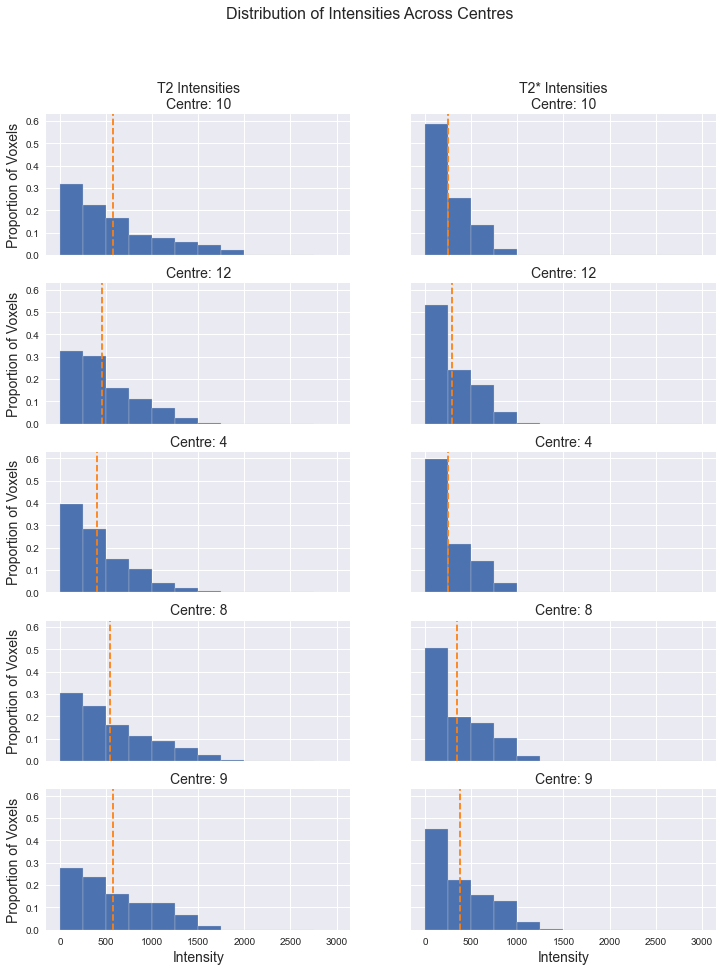

In [7]:
fig, ax = plt.subplots(5, 2, figsize= (12, 15), sharex=True, sharey=True)

t2_bins = get_bins(np.concatenate(list(t2_data.values())), bin_width=250)
t2s_bins = get_bins(np.concatenate(list(t2s_data.values())), bin_width=250)

for i,c in enumerate(np.unique(centres_df['centerId'])):
    c_subj = centres_df[centres_df['centerId']==c]['patientId']
    
    centre_t2_values = np.concatenate([t2_data[str(s)].ravel() for s in c_subj])
    ax[i, 0].hist(centre_t2_values, weights=np.ones(len(centre_t2_values)) / len(centre_t2_values),
              edgecolor='lightgray', bins=t2_bins)
    ax[i, 0].axvline(centre_t2_values.mean(), color='tab:orange', linestyle='dashed')
    ax[i, 0].set_ylabel('Proportion of Voxels', fontsize=14)
    title = 'T2 Intensities\nCentre: {}' if i==0 else 'Centre: {}'
    ax[i, 0].set_title(title.format(c), fontsize=14)
    
    centre_t2s_values = np.concatenate([t2s_data[str(s)].ravel() for s in c_subj])
    ax[i, 1].hist(centre_t2s_values, weights=np.ones(len(centre_t2s_values)) / len(centre_t2s_values),
              edgecolor='lightgray', bins=t2s_bins)        
    ax[i, 1].axvline(centre_t2s_values.mean(), color='tab:orange', linestyle='dashed')
    title = 'T2* Intensities\nCentre: {}' if i==0 else 'Centre: {}'
    ax[i, 1].set_title(title.format(c), fontsize=14)

ax[4,0].set_xlabel('Intensity', fontsize=14)
ax[4,1].set_xlabel('Intensity', fontsize=14)
plt.suptitle('Distribution of Intensities Across Centres', fontsize=16)
plt.show()

Failed to find a Ghostscript installation.  Distillation step skipped.


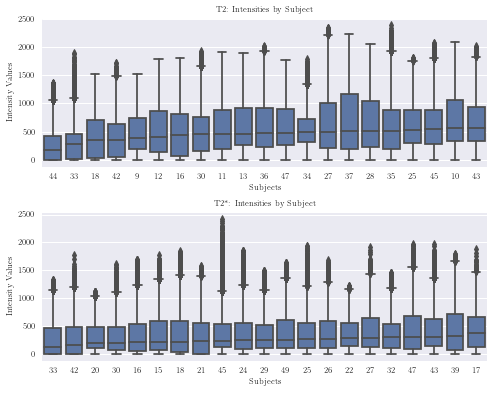

In [96]:
data_flattened = [t2_data[subj].ravel() for subj in centre8_subjects]
data_sorted, subj_sorted = zip(*sorted(zip(data_flattened, centre8_subjects), key=lambda x: np.median(x[0])))

fig, axes = plt.subplots(2, 1, figsize=get_figsize(fig_height=5.5, columns=2))

sns.boxplot(data=data_sorted[::2], color='#5173b1', ax=axes[0])
axes[0].set_xticklabels(subj_sorted[::2])
axes[0].set_xlabel('Subjects')
axes[0].set_ylabel('Intensity Values')
axes[0].set_title('T2: Intensities by Subject')

data_flattened = [t2s_data[subj].ravel() for subj in centre8_subjects]
data_sorted, subj_sorted = zip(*sorted(zip(data_flattened, centre8_subjects), key=lambda x: np.median(x[0])))

sns.boxplot(data=data_sorted[::2], color='#5173b1')
axes[1].set_xticklabels(subj_sorted[::2])
axes[1].set_xlabel('Subjects')
axes[1].set_ylabel('Intensity Values')
axes[1].set_title('T2*: Intensities by Subject')
fig.tight_layout()

fig.savefig('Report/Plots/boxplot_by_subject.eps')

##### Show the top patch and bottom patch separately for each subject to assess intra-patient and inter-patient variability.
** Note: the first patch in the data is from the bottom of the image, and the last patch is from the top of the image. This results from the order in SCT processing, 0 in the z-axis corresponds to the bottom of the image.

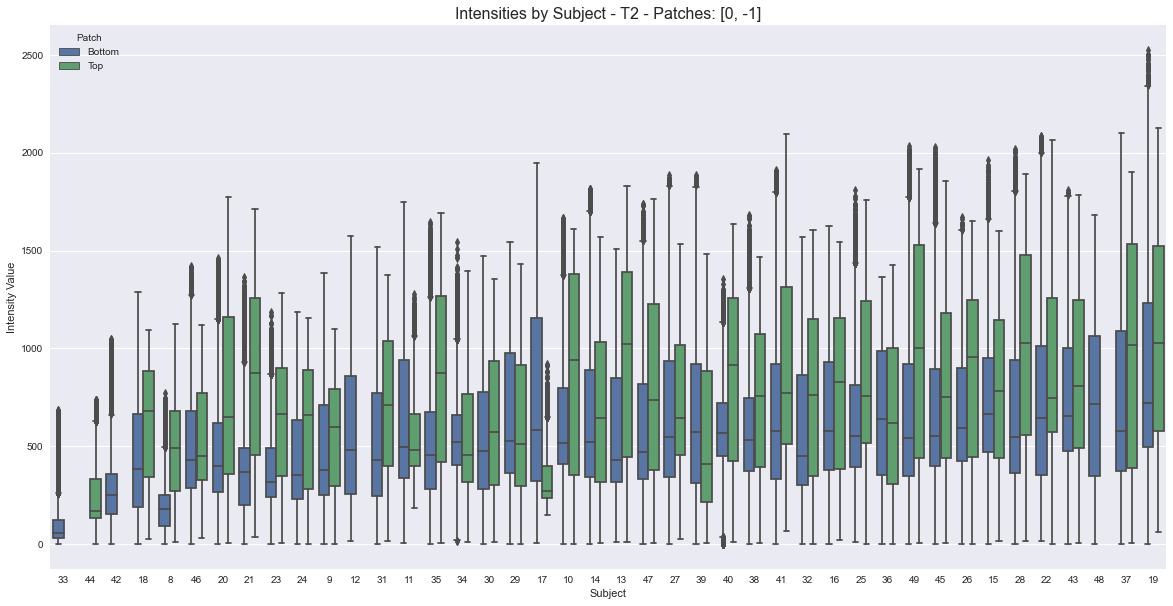

In [8]:
def boxplot_subj_patch_split(data, patch_ind=[0,-1], title=''):
    data_flattened = [data[subj][i].ravel() for subj in centre8_subjects for i in patch_ind]

    bt_patches_wide_df = pd.DataFrame(np.array(data_flattened).transpose(), 
                                      columns=[subj + '_' + patch for subj in centre8_subjects for patch in ['Bottom', 'Top']])
    bt_patches_long_df = bt_patches_wide_df.melt(var_name='Subject_Patch', value_name='Intensity Value')
    bt_patches_long_df[['Subject','Patch']] = bt_patches_long_df.Subject_Patch.str.split('_', expand=True)

    plt.figure(figsize=(20,10))
    sns.boxplot(x='Subject', y='Intensity Value', hue='Patch', 
                data=bt_patches_long_df[bt_patches_long_df['Intensity Value']>0], 
               order=bt_patches_long_df[bt_patches_long_df['Intensity Value']>0].groupby('Subject').median().sort_values('Intensity Value').index
               )
    plt.title('Intensities by Subject - {} - Patches: {}'.format(title, str(patch_ind)),fontsize=16)

boxplot_subj_patch_split(t2_data, patch_ind=[0,-1], title='T2')
boxplot_subj_patch_split(t2s_data, patch_ind=[0,-1], title='T2*')

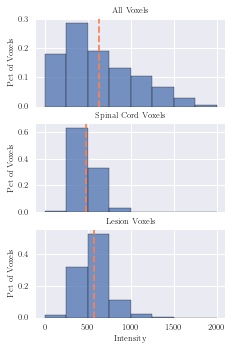

In [41]:
# (data, bin_width, xlab='', ylab='', title='', subtitle='')
fig, axes = plt.subplots(3,1, sharex=True, figsize=(3.39, 5.5))
plot_hist(patches_t2[patches_t2>0].ravel(), prop=True, bin_width=250, xmin=0, xmax=2000, 
          xlab='Intensity', ylab='Pct of Voxels', title='All Voxels', ax=axes[0])
plot_hist(patches_t2_SC[patches_t2_SC>0].ravel(), prop=True, bin_width=250, xmin=0, xmax=2000, 
          xlab='Intensity', ylab='Pct of Voxels', subtitle='Spinal Cord Voxels', ax=axes[1])
plot_hist(patches_t2[patches_lesion==1].ravel(), prop=True, bin_width=250, xmin=0, xmax=2000, 
          xlab='Intensity', ylab='Pct of Voxels', subtitle='Lesion Voxels', ax=axes[2])

In [47]:
# Function to collapse the data arrays and concatenate all subject data.
collapse = lambda data: np.concatenate([data[subj].ravel() for subj in centre8_subjects])

# Flatten all subject data and combine into a long dataframe with a column indicating the subject number.
# Note: uses a lot of memory.
all_data_df = pd.DataFrame(
    np.concatenate((
        # Get the list of subjects (repeated for each row of subject data). Reshape so it can be combined with the 2D array that follows.
        np.array([subj for subj in centre8_subjects for i in range(t2_data[subj].size)]).reshape(1,-1),
        np.array([collapse(data) for data in [t2_data, t2s_data, lesion_data]]),  # Collapse each data dict into 1D array.
        np.where(collapse(t2_SC_data)==-1, 0, 1).reshape(1,-1)  # Get a flag for the location of the Spinal Cord.
        )
    ).transpose(),
    columns=['Subject', 'T2', 'T2s', 'Lesion', 'Spinal Cord']
)

# Convert columns to numeric to free up memory.
all_data_df[['T2', 'T2s', 'Lesion', 'Spinal Cord']] = all_data_df[['T2', 'T2s', 'Lesion', 'Spinal Cord']].apply(pd.to_numeric)

gc.collect() # Clean up memory.

# Categorise the voxels as 1) Lesion Voxels, 2) Non-Lesion Spinal Cord Voxels, or 3) Non-Spinal Cord Voxels.
all_data_df['category'] = np.where(all_data_df['Lesion']==1, 1, np.where(all_data_df['Spinal Cord']==1, 2, 3))

In [16]:
# Write/Read data from file since the above cell takes >6 minutes to run.
# all_data_df.to_csv(os.path.join('Data', 'all_data_df.csv'), index=False)  # 2mins to run

# all_data_df = pd.read_csv(os.path.join('ot_da_v0', 'Data', 'all_data_df.csv'), 
#                           dtype={'Subject': np.int16, 'T2': np.float32, 'T2s': np.float32, 'Lesion': np.int8, 'Spinal Cord': np.int8, 'category': np.int8}
#                          )  # 11 seconds to run.

#### Boxplots per subject split by Lesion / Spinal Cord / Non-Spinal Cord

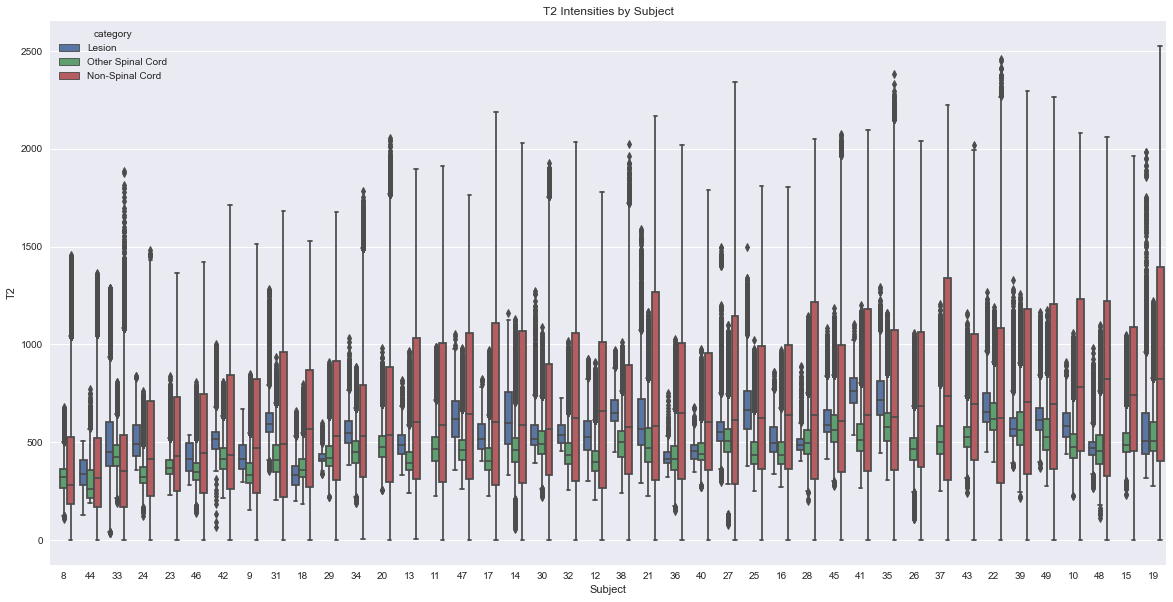

In [13]:
plt.figure(figsize=(20,10))
g = sns.boxplot(x='Subject', y='T2', hue='category', 
            data=all_data_df[all_data_df['T2']>0],
            order=all_data_df[all_data_df['T2']>0].groupby('Subject').median().sort_values('T2').index
            )
plt.title('T2 Intensities by Subject')

for t, l in zip(g.legend_.texts, ['Lesion', 'Other Spinal Cord', 'Non-Spinal Cord']):
    t.set_text(l)
plt.show()

34, 42   47, 19, 38

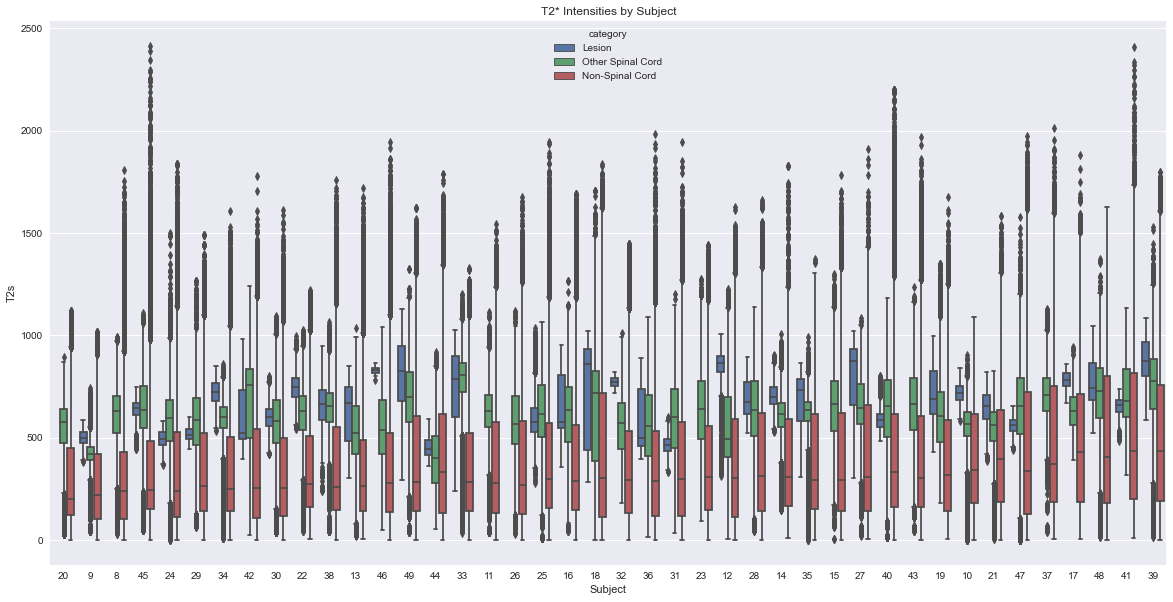

In [14]:
plt.figure(figsize=(20,10))
g = sns.boxplot(x='Subject', y='T2s', hue='category', 
            data=all_data_df[all_data_df['T2s']>0],
            order=all_data_df[all_data_df['T2s']>0].groupby('Subject').median().sort_values('T2s').index
            )
plt.title('T2* Intensities by Subject')

for t, l in zip(g.legend_.texts, ['Lesion', 'Other Spinal Cord', 'Non-Spinal Cord']):
    t.set_text(l)
plt.show()

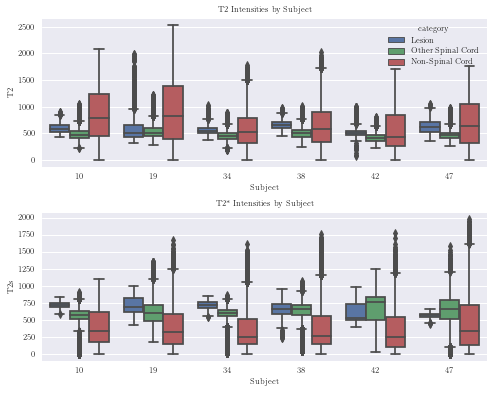

Failed to find a Ghostscript installation.  Distillation step skipped.


In [48]:
fig, axes = plt.subplots(2, 1, figsize=get_figsize(fig_height=5.5, columns=2))
g = sns.boxplot(x='Subject', y='T2', hue='category', ax=axes[0],
            data=all_data_df[(all_data_df['T2']>0) & (all_data_df['Subject'].isin([10,34,42,47,19,38]))]
            )
axes[0].set_title('T2 Intensities by Subject')

for t, l in zip(g.legend_.texts, ['Lesion', 'Other Spinal Cord', 'Non-Spinal Cord']):
    t.set_text(l)

g = sns.boxplot(x='Subject', y='T2s', hue='category', ax=axes[1], 
            data=all_data_df[(all_data_df['T2s']>0) & (all_data_df['Subject'].isin([10,34,42,47,19,38]))]
            )
axes[1].set_title('T2* Intensities by Subject')

g.legend_.remove()
fig.tight_layout()
plt.show()
fig.savefig('Report/Plots/boxplot_by_category.eps')

#### Joint Distribution Plots

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
Failed to find a Ghostscript installation.  Distillation step skipped.


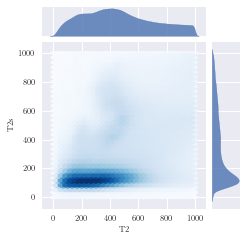

In [43]:
# Hex plots on the whole dataset (for non-zero intensities)
# sns.jointplot(x='T2', y='T2s', 
#               kind='hex',
#              data=all_data_df[(all_data_df['T2']>0) & (all_data_df['T2s']>0)],
#               height=3.39
#              )

g = sns.JointGrid(x='T2', y='T2s', height=3.39,
        data=all_data_df[(all_data_df['T2']>0) & (all_data_df['T2s']>0) & (all_data_df['T2']<1000) & (all_data_df['T2s']<1000)])
g.plot_joint(plt.hexbin, gridsize=(30,30), cmap=sns.color_palette('Blues', as_cmap=True))
g.plot_marginals(sns.kdeplot, fill=True, alpha=0.8)

plt.savefig('Report/Plots/hex_cropped.eps') 

In [67]:
# Sample points for each subject as otherwise too much data for the KDE computation below.
data_sample = (
    all_data_df[(all_data_df['T2s']>0) & (all_data_df['T2']>0)]
    .groupby('Subject', group_keys=False)
    .apply(lambda x: x.sample(5000, random_state=2021))
)

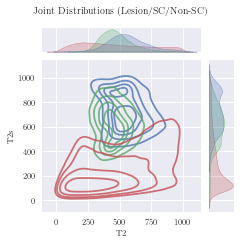

In [89]:
# # 7 mins to run cell based on sample of 5k points from each subject.
# sns.jointplot(x='T2', y='T2s', 
#               kind='kde',
#               color="blue",
#               fill=True,
#               data = data_sample,
#               common_norm=False
#              )
# plt.suptitle('Overall Joint Distribution (Sample of each Subject)')

pal = sns.color_palette('deep')
palette_dict = {1: pal[0], 2: pal[2], 3: pal[3]}
g = sns.jointplot(x='T2', y='T2s', 
              kind='kde',
              hue='category',
              joint_kws={'alpha': 0.8, 'common_norm':False, 'fill':False, 'levels':5, 'thresh':0.2},
              marginal_kws={'common_norm':False, 'fill':True},
              data=data_sample[(data_sample['T2']<1000) & (data_sample['T2s']<1000)],
              palette=palette_dict,
              height=3.39,
              legend=False
             )
# for t, l in zip(g.ax_joint.legend_.texts, ['Lesion', 'Other SC', 'Non-SC']):
#     t.set_text(l)
    
plt.suptitle('Joint Distributions (Lesion/SC/Non-SC)')
plt.tight_layout()
plt.savefig('Report/Plots/jointdist_by_category.pdf')

#### Kernel Density Plots

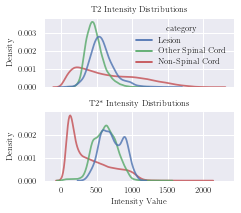

In [74]:
fig, axes = plt.subplots(2,1, figsize=get_figsize(fig_height=3), sharex=True)

pal = sns.color_palette('deep')
palette_dict = {1: pal[0], 2: pal[2], 3: pal[3]}

g = sns.kdeplot(x='T2', hue='category', data=data_sample, ax=axes[0], common_norm=False, palette=palette_dict)
axes[0].set_title('T2 Intensity Distributions')#, fontsize=16)

for t, l in zip(g.legend_.texts, ['Lesion', 'Other Spinal Cord', 'Non-Spinal Cord']):
    t.set_text(l)

sns.kdeplot(x='T2s', hue='category', data=data_sample, ax=axes[1], common_norm=False, legend=False, palette=palette_dict)
axes[1].set_title('T2* Intensity Distributions')# , fontsize=16)
axes[1].set_xlabel('Intensity Value') #, fontsize=14)

# Set lighter transparency on lines.
for line in axes[0].get_lines():
    line.set_alpha(0.8)
for line in axes[1].get_lines():
    line.set_alpha(0.8)

fig.tight_layout()
plt.show()
fig.savefig('Report/Plots/dist_by_category.pdf')

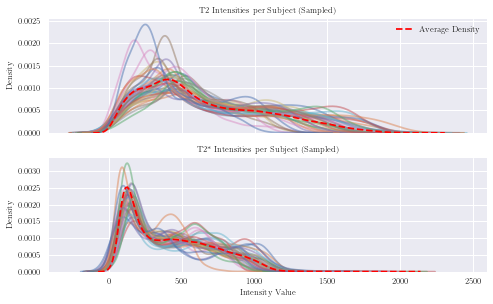

In [81]:
fig, axes = plt.subplots(2,1, figsize=get_figsize(columns=2), sharex=True)

sns.kdeplot(x='T2', hue='Subject', data=data_sample, ax=axes[0], common_norm=False, legend=False, palette='deep')
sns.kdeplot(x='T2',  data=data_sample, ax=axes[0], color='red', linestyle="--")
axes[0].set_title('T2 Intensities per Subject (Sampled)')
axes[0].legend(handles=[axes[0].lines[-1]], labels=["Average Density"])

sns.kdeplot(x='T2s', hue='Subject', data=data_sample, ax=axes[1], common_norm=False, legend=False, palette='deep')
sns.kdeplot(x='T2s',  data=data_sample, ax=axes[1], legend=False, color='red', linestyle="--")
axes[1].set_title('T2* Intensities per Subject  (Sampled)')
axes[1].set_xlabel('Intensity Value')

# Set lighter transparency on lines.
for line in axes[0].get_lines()[:-1]:
    line.set_alpha(0.5)
for line in axes[1].get_lines()[:-1]:
    line.set_alpha(0.5)

fig.tight_layout()
plt.show()

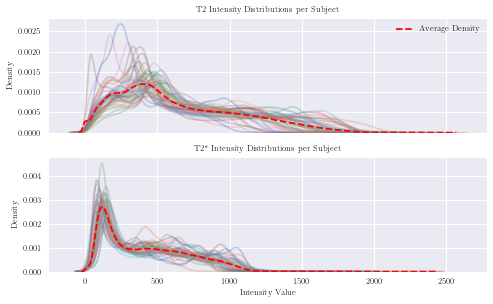

In [97]:
# 11 mins to run.
fig, axes = plt.subplots(2,1, figsize=get_figsize(columns=2), sharex=True)

sns.kdeplot(x='T2', hue='Subject', ax=axes[0], legend=False, data=all_data_df[all_data_df['T2']>0],
           common_norm=False, palette='deep')
sns.kdeplot(x='T2',  data=all_data_df[all_data_df['T2s']>0], ax=axes[0], color='red', linestyle="--")
axes[0].set_title('T2 Intensity Distributions per Subject')
axes[0].legend(handles=[axes[0].lines[-1]], labels=["Average Density"])

sns.kdeplot(x='T2s', hue='Subject', ax=axes[1], legend=False, data=all_data_df[all_data_df['T2s']>0],
            common_norm=False,palette='deep')
sns.kdeplot(x='T2s',  data=all_data_df[all_data_df['T2s']>0], ax=axes[1], legend=False, color='red', linestyle="--")
axes[1].set_title('T2* Intensity Distributions per Subject')
axes[1].set_xlabel('Intensity Value')

# Set lighter transparency on lines.
for line in axes[0].get_lines()[:-1]:
    line.set_alpha(0.3)
for line in axes[1].get_lines()[:-1]:
    line.set_alpha(0.3)

fig.tight_layout()
plt.show()
fig.savefig('Report/Plots/density_by_subject.pdf')

#### Standardising data with to Mean=0 and SD=1

In [72]:
t2_mean = all_data_df[all_data_df['T2']>0]['T2'].mean()
t2_std = all_data_df[all_data_df['T2']>0]['T2'].std()
t2s_mean = all_data_df[all_data_df['T2s']>0]['T2s'].mean()
t2s_std = all_data_df[all_data_df['T2s']>0]['T2s'].std()

all_data_df['T2_standardised'] = (all_data_df['T2'] - t2_mean)/t2_std
all_data_df['T2s_standardised'] = (all_data_df['T2s'] - t2s_mean)/t2s_std

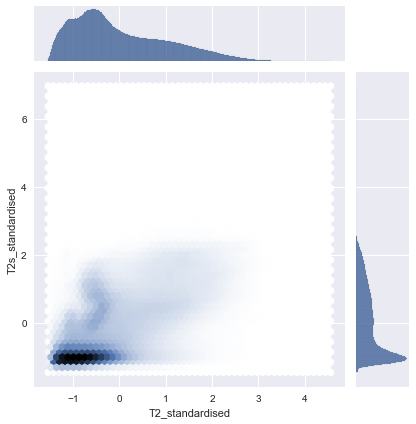

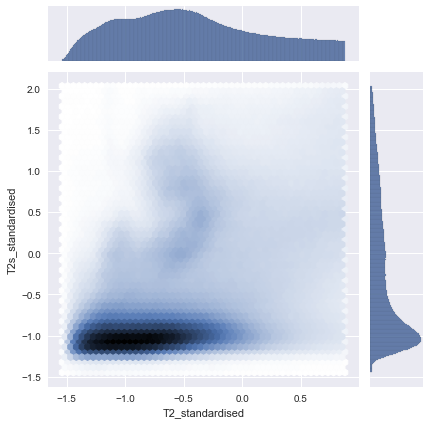

In [78]:
# Hex plots on the whole dataset (for non-zero intensities)
sns.jointplot(x='T2_standardised', y='T2s_standardised', 
              kind='hex',
             data=all_data_df[(all_data_df['T2']>0) & (all_data_df['T2s']>0)])
# 'Zoomed in' to region where both intensities are below 1,000.
sns.jointplot(x='T2_standardised', y='T2s_standardised', 
              kind='hex',
             data=all_data_df[(all_data_df['T2']>0) & (all_data_df['T2s']>0) & (all_data_df['T2']<1000) & (all_data_df['T2s']<1000)]
             )

### Summarising Lesion & Patch Data

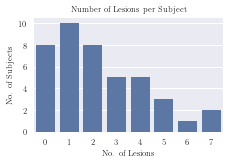

In [86]:
lesion_count = np.unique([int(n_lesions[subj]) for subj in centre8_subjects], return_counts=True)
sns.barplot(x=lesion_count[0], y=lesion_count[1], color='#5173b1')
plt.xlabel('No. of Lesions')
plt.ylabel('No. of Subjects')
plt.title('Number of Lesions per Subject')
plt.show()

In [84]:
lesion_voxel_count = np.unique(patches_lesion, return_counts=True)[1]
lesion_voxel_prop = lesion_voxel_count[1]/sum(lesion_voxel_count)
print('Overall in the dataset, {}% of voxels contain a lesion.\n\t({} voxels out of a total {})'.format(
    round(lesion_voxel_prop*100, 3), lesion_voxel_count[1], sum(lesion_voxel_count)))

lesion_voxel_raw_count_patches = [np.unique(patch, return_counts=True)[1] for patch in patches_lesion]
lesion_voxel_count_patches = [0 if len(x)==1 else x[1] for x in lesion_voxel_raw_count_patches]
lesion_voxel_prop_patches = [0 if len(x)==1 else x[1]/sum(x) for x in lesion_voxel_raw_count_patches]
total_voxel_count_patches = [sum(x) for x in lesion_voxel_raw_count_patches]

df_patch_count = pd.DataFrame(zip(patches_subjects, lesion_voxel_prop_patches, lesion_voxel_count_patches, total_voxel_count_patches), 
                              columns=['subject', 'prop_lesion', 'voxels_lesion', 'total_voxels'])

Overall in the dataset, 0.467% of voxels contain a lesion.
	(138945 voxels out of a total 29749248)


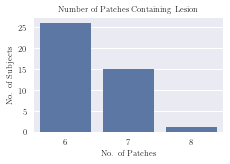

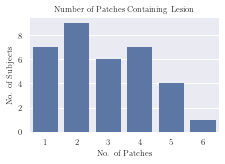

In [85]:
sns.barplot(x='index',y='subject', color='#5173b1',
            data= df_patch_count['subject']  
                .value_counts().value_counts() 
                .sort_index().reset_index()
           )

plt.title('Number of Patches per Subject')
plt.ylabel('No. of Subjects')
plt.xlabel('No. of Patches')
plt.show()

sns.barplot(x='index', y='subject', color='#5173b1',
            data=df_patch_count[df_patch_count['voxels_lesion'] > 0]['subject']  
                .value_counts().value_counts()
                .sort_index().reset_index()
           ) 

plt.title('Number of Patches Containing Lesion')
plt.ylabel('No. of Subjects')
plt.xlabel('No. of Patches')
plt.show()

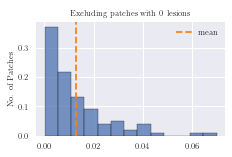

In [20]:
plot_hist([p for p in lesion_voxel_prop_patches if p>0], 0.005, xlab='% of voxels containing lesion', ylab='No. of Patches', 
          title='% of lesion voxels in each patch', subtitle = 'Excluding patches with 0 lesions')

# plot_hist(lesion_voxel_count_patches, 500, xlab='# of voxels containing lesion', ylab='# Patches', title='Number of lesion voxels in each patch')

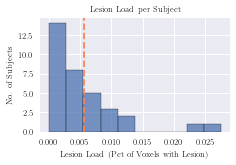

In [94]:
totals_by_subj = df_patch_count.groupby('subject')[['voxels_lesion', 'total_voxels']].sum()

totals_by_subj['prop_lesion'] = totals_by_subj['voxels_lesion']/totals_by_subj['total_voxels']

# plot_hist(totals_by_subj['voxels_lesion'], bin_width=2500, 
#           xlab='# of Lesion Voxels', ylab='# Subjects', title='Total Lesion Voxels per Subject')
# plot_hist(totals_by_subj[totals_by_subj['voxels_lesion']>0]['voxels_lesion'], bin_width=2500,
#         xlab='# of Lesion Voxels', ylab='# Subjects', title='Total Lesion Voxels per Subject',
#          subtitle='Subjects with 0 Lesions Excluded')

# # Plot Distrbution of % Lesion Voxels rather than Absolute Number of Voxels.
# plot_hist(totals_by_subj['prop_lesion'], bin_width=0.002,
#         xlab='% of Voxels with Lesion', ylab='# Subjects', title='% Voxels with Lesion per Subject')
plot_hist(totals_by_subj[totals_by_subj['prop_lesion']>0]['prop_lesion'], bin_width=0.0025,
        xlab='Lesion Load (Pct of Voxels with Lesion)', ylab='No. of Subjects', title='Lesion Load per Subject')

Text(0.5, 0, 'Subject')

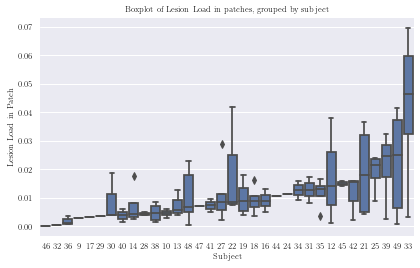

In [88]:
grouped = df_patch_count[df_patch_count['prop_lesion'] > 0].groupby('subject')
df_sort =  pd.DataFrame({col:vals['prop_lesion'] for col,vals in grouped})
df_sort = df_sort[df_sort.median().sort_values().index]

fig, ax = plt.subplots(figsize=(6.69,4))
sns.boxplot(data=df_sort, ax=ax, color='#5173b1')
plt.title('Boxplot of Lesion Load in patches, grouped by subject')#, fontsize=16)
# plt.title('Patches with 0 lesions excluded', fontsize=14)
plt.ylabel('Lesion Load in Patch')#, fontsize=14)
plt.xlabel('Subject')#, fontsize=14)